In [102]:
from tvDatafeed import TvDatafeed, Interval
import mplfinance as mpf
import pandas as pd
import ta  # module for technical indicators
import ta.momentum
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [106]:
symbol = "AMD"
exchange = "NASDAQ"
interval = Interval.in_1_minute
n_bars = 5000
tv = TvDatafeed()

df = tv.get_hist(symbol=symbol, exchange=exchange, interval=interval, n_bars=n_bars)
df = df.drop(columns=['symbol'])


# Funkcje pomocnicze
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(series, short=12, long=26, signal=9):
    ema_short = series.ewm(span=short, adjust=False).mean()
    ema_long = series.ewm(span=long, adjust=False).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    return macd_line - signal_line

def compute_adx(high, low, close, period=14):
    tr = pd.concat([
        high - low,
        abs(high - close.shift(1)),
        abs(low - close.shift(1))
    ], axis=1).max(axis=1)

    dm_plus = (high - high.shift(1)).clip(lower=0)
    dm_minus = (low.shift(1) - low).clip(lower=0)

    tr_smooth = tr.rolling(window=period).sum()
    dm_plus_smooth = dm_plus.rolling(window=period).sum()
    dm_minus_smooth = dm_minus.rolling(window=period).sum()

    di_plus = 100 * (dm_plus_smooth / tr_smooth)
    di_minus = 100 * (dm_minus_smooth / tr_smooth)
    dx = 100 * abs(di_plus - di_minus) / (di_plus + di_minus)
    adx = dx.rolling(window=period).mean()

    return adx

def compute_bollinger_bands(series, window=20, num_std=2):
    sma = series.rolling(window=window).mean()
    std_dev = series.rolling(window=window).std()
    upper_band = sma + (num_std * std_dev)
    lower_band = sma - (num_std * std_dev)
    return upper_band, lower_band


# Cechy cenowe
df['Price_Change'] = df['close'].pct_change()
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['SMA_50'] = df['close'].rolling(window=50).mean()
df['SMA_200'] = df['close'].rolling(window=200).mean()

# RSI i MACD
df['RSI_14'] = compute_rsi(df['close'], window=14)
df['MACD'] = compute_macd(df['close'])

# Wolumen
df['Volume_MA'] = df['volume'].rolling(window=50).mean()
df['Volume_Spike'] = df['volume'] / df['Volume_MA']

# Dystans od SMA
df['SMA_20_Distance'] = (df['SMA_20'] - df['close']) / df['close']

# ADX i Bollinger Bands
df['ADX'] = compute_adx(df['high'], df['low'], df['close'], period=14)
df['Bollinger_Upper'], df['Bollinger_Lower'] = compute_bollinger_bands(df['close'])
df['Normalized_BB'] = ((df['close'] - df['Bollinger_Lower']) / (df['Bollinger_Upper'] - df['Bollinger_Lower'])) * 100

# Normalizacja
features_to_normalize = ['Price_Change', 'SMA_20_Distance', 'Volume_Spike', 'ADX', 'MACD']
for feature in features_to_normalize:
    df[feature] = (df[feature] - df[feature].mean()) / df[feature].std()


# df['Return_5_Days'] = df['close'].pct_change(periods=5) * 100
# df['Return_4_Days'] = df['close'].pct_change(periods=4) * 100
# df['Return_3_Days'] = df['close'].pct_change(periods=3) * 100
# df['Return_2_Days'] = df['close'].pct_change(periods=2) * 100
# df['Return_1_Days'] = df['close'].pct_change(periods=1) * 100

# # Obliczanie średniej z tych zwrotów
# df['Target'] = df[['Return_2_Days', 'Return_3_Days', 'Return_4_Days', 'Return_5_Days']].shift(-5).mean(axis=1)

# Średnia z następnych 5 dni
df['Mean_5_Days_Ahead'] = df['close'].shift(-5).rolling(window=5, min_periods=1).mean()

# Procentowy wzrost względem aktualnej daty (zmiana procentowa z 5 dni później)
df['Target'] = (df['close'].shift(-5) - df['close']) / df['close'] * 100


# Usuwamy wiersze z NaN w kolumnie 'Target'
#df.dropna(subset=['Target'], inplace=True)
df = df.drop(columns=['open', 'close', 'high', 'low'])
df = df.dropna()

df

,volume,Price_Change,SMA_20,SMA_50,SMA_200,RSI_14,MACD,Volume_MA,Volume_Spike,SMA_20_Distance,ADX,Bollinger_Upper,Bollinger_Lower,Normalized_BB,Mean_5_Days_Ahead,Target
datetime,,,,,,,,,,,,,,,,
2025-01-06 19:59:00,22914.0,-1.480263,129.99575,130.1491,129.797800,21.428571,-0.603597,7324.12,2.180348,0.910835,0.140638,130.290391,129.701109,-20.551918,129.302,-0.254669
2025-01-06 20:00:00,16543.0,-0.887217,129.96075,130.1345,129.800900,16.494845,-0.888514,7472.24,1.225097,1.172101,0.275670,130.341860,129.579640,-19.632087,129.314,0.046357
2025-01-06 20:01:00,13254.0,-1.604179,129.91425,130.1151,129.803850,12.903226,-1.312574,7571.42,0.741123,1.681318,0.392605,130.431564,129.396936,-22.900646,129.352,0.147104
2025-01-06 20:02:00,8134.0,1.321932,129.87800,130.1005,129.808850,24.475524,-1.243163,7616.66,0.028206,1.098443,0.625028,130.438811,129.317189,5.600050,129.382,0.115938
2025-01-06 20:03:00,6795.0,-0.530497,129.83500,130.0823,129.812250,25.362319,-1.216678,7552.16,-0.147441,1.205676,0.787369,130.438272,129.231728,4.829646,129.450,0.262975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-24 21:50:00,42749.0,1.394120,122.40475,122.4488,122.791075,71.774194,0.479888,6580.82,5.697303,-0.638028,-0.156485,122.551414,122.258086,137.018761,122.822,0.171205
2025-01-24 21:51:00,5893.0,0.384377,122.41925,122.4520,122.785525,73.484848,0.695434,6589.70,-0.153152,-0.746298,-0.059602,122.622753,122.215747,123.893304,122.848,0.105932
2025-01-24 21:52:00,26199.0,1.139264,122.44075,122.4578,122.780475,80.120482,0.999097,7065.30,2.785638,-1.122893,0.018387,122.736692,122.144808,127.591140,122.847,-0.004068


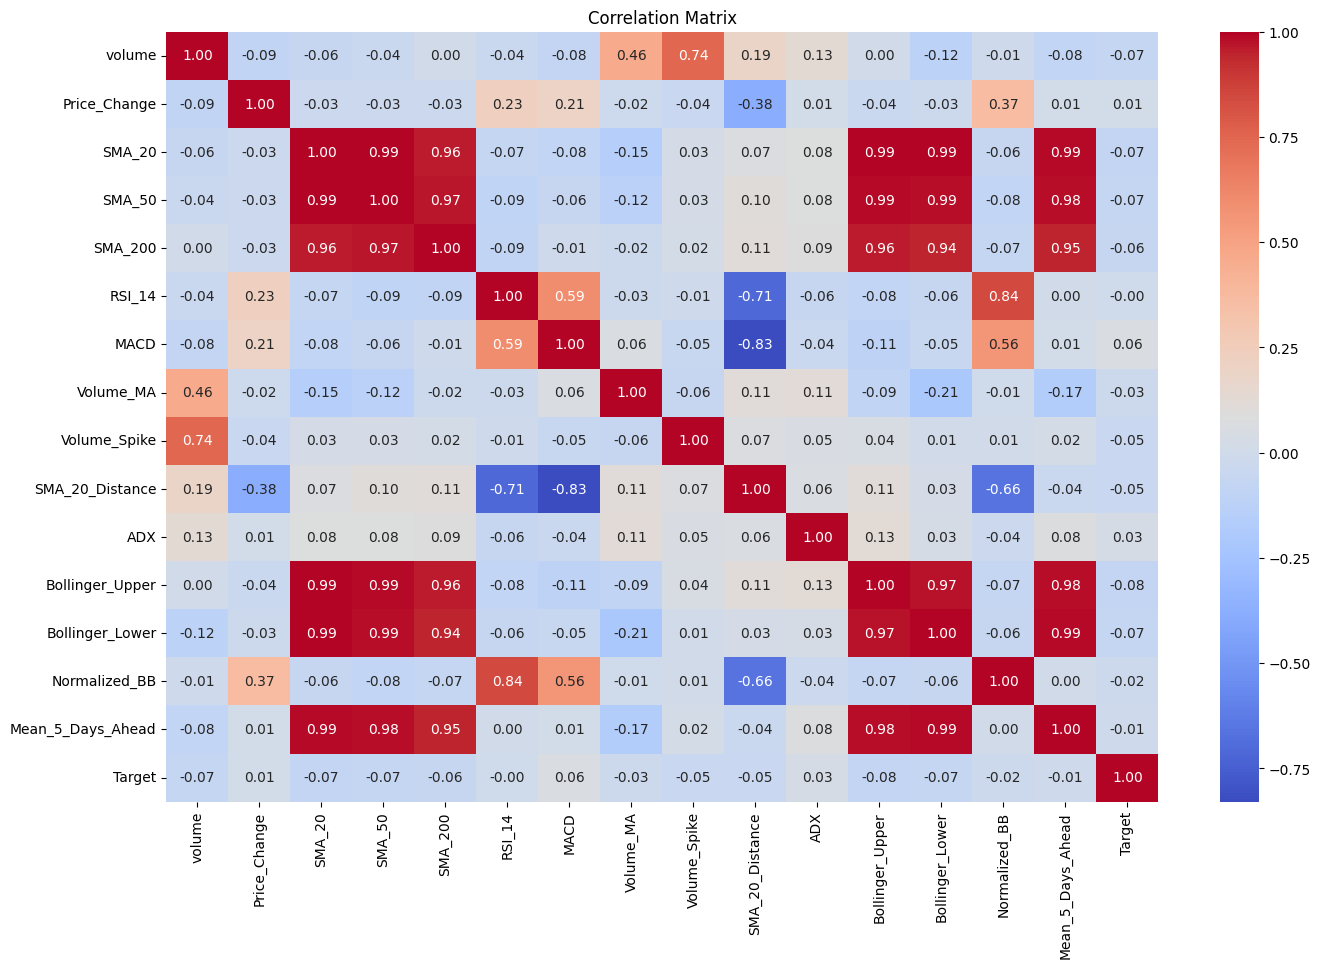

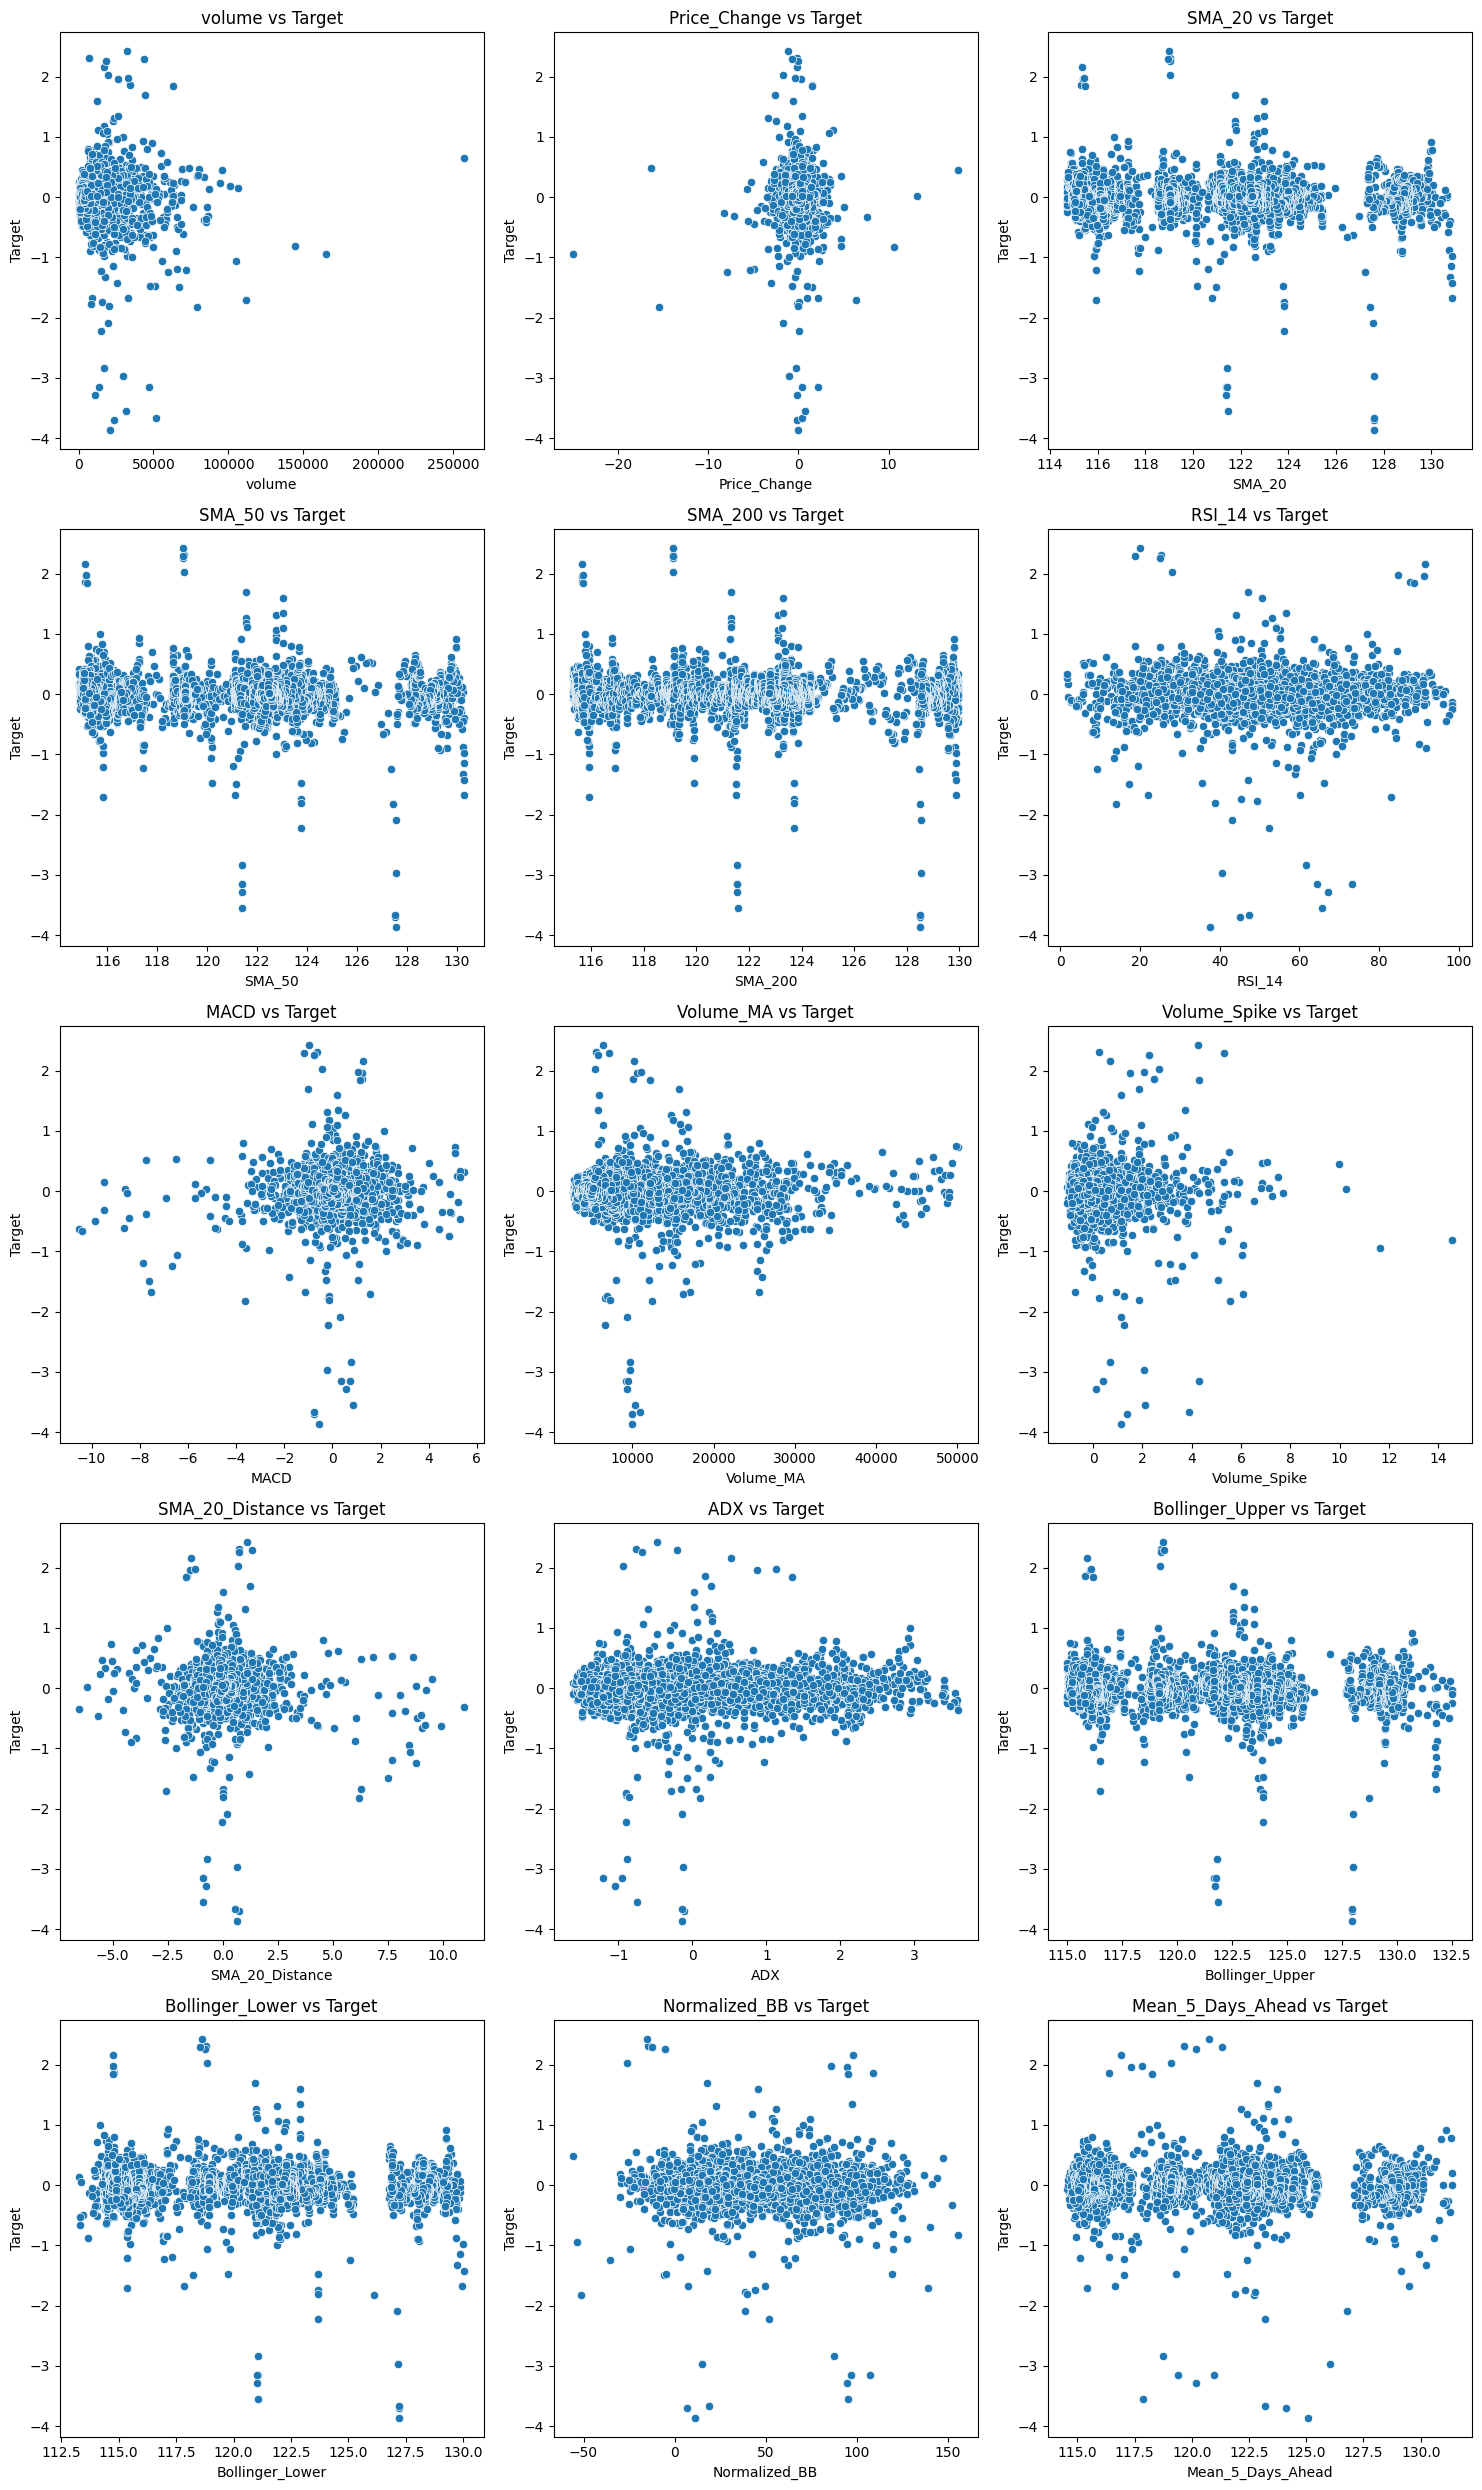

In [104]:
correlation_matrix = df.corr()

plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

n_features = len(df.drop(columns=['Target']).columns)
n_cols = 3  # Liczba kolumn w siatce
n_rows = np.ceil(n_features / n_cols).astype(int)  # Liczba wierszy w siatce
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

for i, feature in enumerate(df.drop(columns=['Target']).columns):
    row = i // n_cols  
    col = i % n_cols   

    sns.scatterplot(x=df[feature], y=df['Target'], ax=axes[row, col])
    axes[row, col].set_title(f"{feature} vs Target")
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Target')

for i in range(n_features, n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout() 
plt.show()


We Will do PCA, to get best vectors out of this data:

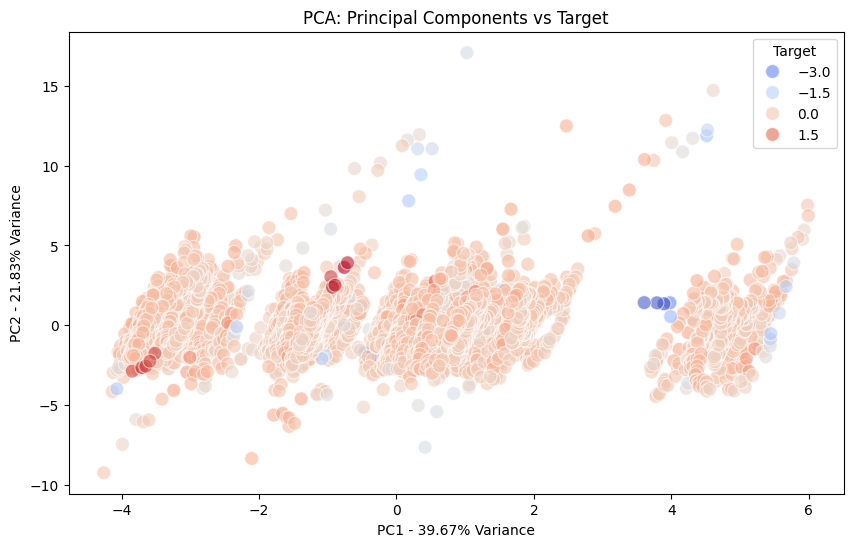

Explained Variance by each component: PC1: 39.67%, PC2: 21.83%


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Wybór cech, które chcesz uwzględnić w PCA
features = df.drop(columns=['Target'])  

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pca = PCA(n_components=2) 
pca_components = pca.fit_transform(features_scaled)

df_pca = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])

explained_variance = pca.explained_variance_ratio_

df_pca['Target'] = df['Target'].values  # Dodajemy Target, żeby sprawdzić jego zależność

# Wykres rozrzutu komponentów głównych
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df_pca['Target'], palette='coolwarm', s=100, alpha=0.6)
plt.title("PCA: Principal Components vs Target")
plt.xlabel(f"PC1 - {explained_variance[0]*100:.2f}% Variance")
plt.ylabel(f"PC2 - {explained_variance[1]*100:.2f}% Variance")
plt.show()

# Wydrukowanie procentowej zmienności wyjaśnionej przez każdy komponent
print(f"Explained Variance by each component: PC1: {explained_variance[0]*100:.2f}%, PC2: {explained_variance[1]*100:.2f}%")


In [77]:
from scipy.stats import spearmanr

correlations = {}
for col in df.columns:
    if col != 'Target':
        correlations[col] = spearmanr(df[col], df['Target'])[0]

correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
print(correlations)


[('Bollinger_Upper', np.float64(-0.06753058226688582)), ('SMA_20', np.float64(-0.061296105095977126)), ('SMA_50', np.float64(-0.06117044962333809)), ('Bollinger_Lower', np.float64(-0.06110027715101765)), ('SMA_200', np.float64(-0.043930038201286645)), ('Normalized_BB', np.float64(-0.02705621345383647)), ('ADX', np.float64(0.026715200046688894)), ('SMA_20_Distance', np.float64(0.024449436692203702)), ('Return_5_Days', np.float64(-0.02261948670082486)), ('Return_3_Days', np.float64(-0.0218889779401213)), ('Price_Change', np.float64(-0.021722321201600787)), ('Return_1_Days', np.float64(-0.021722321201600787)), ('MACD', np.float64(0.020341803151676614)), ('RSI_14', np.float64(-0.018249514797131133)), ('Return_4_Days', np.float64(-0.017652515206841805)), ('Return_2_Days', np.float64(-0.014347273034983916)), ('Volume_Spike', np.float64(-0.0073606961375788605)), ('volume', np.float64(-0.0026648333266728517)), ('Volume_MA', np.float64(0.0013327550603793271))]


In [78]:
from scipy.stats import pointbiserialr

correlation_results = {}
for column in df.drop(columns=['Target']).columns:
    correlation, p_value = pointbiserialr(df[column], df['Target'])
    correlation_results[column] = correlation

# Posortuj wyniki według korelacji
sorted_results = sorted(correlation_results.items(), key=lambda x: abs(x[1]), reverse=True)
print("Point-biserial Correlation Results:")
print(sorted_results)


Point-biserial Correlation Results:
[('Bollinger_Upper', np.float64(-0.07048470412062269)), ('SMA_20', np.float64(-0.06663029725390347)), ('SMA_50', np.float64(-0.0655625686427085)), ('Return_5_Days', np.float64(0.06485658516496992)), ('volume', np.float64(-0.06275757750824133)), ('Return_4_Days', np.float64(0.06252957318515082)), ('Bollinger_Lower', np.float64(-0.061828404889123494)), ('MACD', np.float64(0.05917371064634719)), ('SMA_200', np.float64(-0.05894293857263144)), ('Return_3_Days', np.float64(0.051916144282051734)), ('SMA_20_Distance', np.float64(-0.04699595709481699)), ('Volume_Spike', np.float64(-0.045782517031295614)), ('Return_2_Days', np.float64(0.03141656328319396)), ('ADX', np.float64(0.030101491860049602)), ('Volume_MA', np.float64(-0.022872393387851346)), ('Normalized_BB', np.float64(-0.018086827758113586)), ('Price_Change', np.float64(0.008563020841080477)), ('Return_1_Days', np.float64(0.008563020841080474)), ('RSI_14', np.float64(-0.0017526661156147504))]


In [79]:
# Wanted data
#wanted_features = ['ATR', 'MACD_Histogram', 'Stochastic_K', 'vol_change_pct', 'RSI_pct', 'Target']
#wanted_features = ['Bollinger_Upper', 'Bollinger_Lower', 'Target']
wanted_features = ['Normalized_BB', 'Target']
data = df[wanted_features] 

In [80]:
data.to_csv('../../data/reg_dataset.csv', index=False)